In [1]:
import datetime

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import HIAMCM
import gnss_dtec_gw

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
mpl.rcParams['font.size']      = 12
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = np.array([15, 8])
mpl.rcParams['axes.xmargin']   = 0

In [4]:
def adjust_axes(ax_0,ax_1):
    """
    Force an without colorbar axes to line up with
    an axis that has a colorbar.
    
    ax_0: Axis without colorbar.
    ax_1: Axis with colorbar.
    """
    ax_0_pos    = list(ax_0.get_position().bounds)
    ax_1_pos    = list(ax_1.get_position().bounds)
    ax_0_pos[2] = ax_1_pos[2]
    ax_0.set_position(ax_0_pos)

In [5]:
hiamcm_obj = HIAMCM.HIAMCM()
atec_obj   = gnss_dtec_gw.GNSS_dTEC_GW()

# Plot Original HIAMCM and aTEC Panels

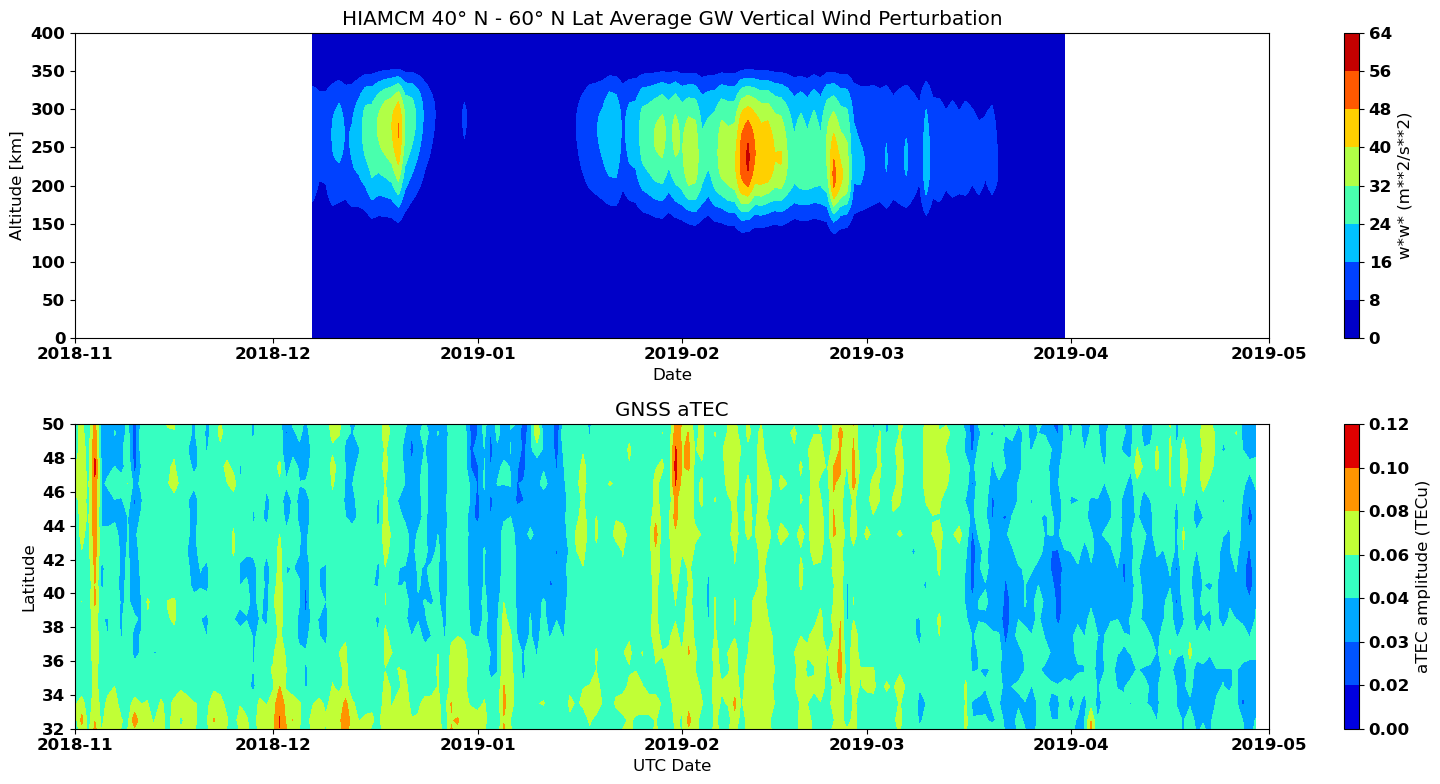

In [6]:
xlim_0 = datetime.datetime(2018,11,1)
xlim_1 = datetime.datetime(2019,5,1)

nrows  = 2
ax_inx = 0

fig = plt.figure(figsize=(16,8))

ax_inx += 1
ax  = fig.add_subplot(nrows,1,ax_inx)
ax_0 = ax
hiamcm_result = hiamcm_obj.plot_ax(ax)
ax.set_xlim(xlim_0,xlim_1)
ax.set_title(hiamcm_result['title'])

ax_inx += 1
ax  = fig.add_subplot(nrows,1,ax_inx)
ax_1 = ax
atec_result  = atec_obj.plot_ax(ax)
ax.set_xlim(xlim_0,xlim_1)
ax.set_title('GNSS aTEC')

fig.tight_layout()

plt.show()

# Reduce HIAMCM

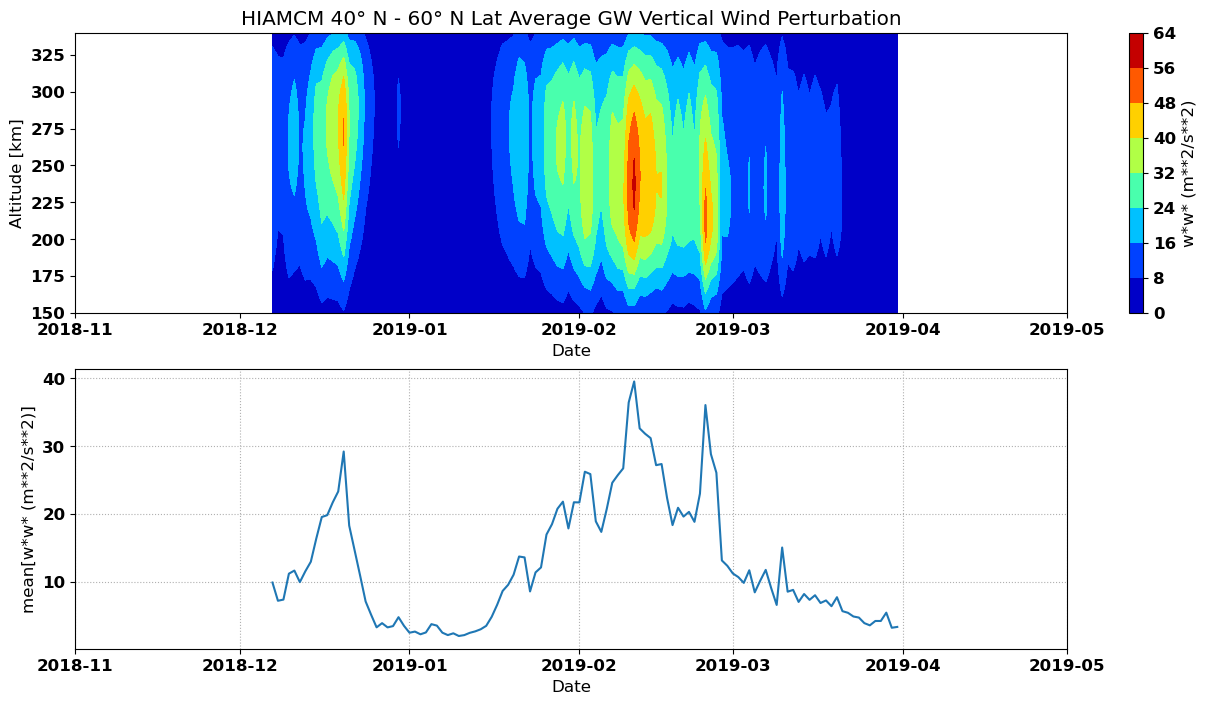

In [7]:
cmap  = 'jet'
alt_0 = 150
alt_1 = 350
ww_da = hiamcm_result['zz']
ww_da = ww_da.where(np.logical_and(ww_da.alts>= alt_0, ww_da.alts < alt_1),drop=True)

ww_mean = ww_da.mean(dim='alts')
ww_df   = pd.DataFrame({'ww_mean':ww_mean},index=ww_da.dates)

nrows  = 2
ax_inx = 0

fig = plt.figure(figsize=(16,8))

ax_inx += 1
ax      = fig.add_subplot(nrows,1,ax_inx)
ax_0 = ax
xx      = ww_da['dates']
yy      = ww_da['alts']
zz      = ww_da
cbar_pcoll  = ax.contourf(xx,yy,zz.T,cmap=cmap)
ax.set_xlim(xlim_0,xlim_1)
ax.set_title(hiamcm_result['title'])
ax.set_xlabel('Date')
ax.set_ylabel('Altitude [km]')
ax.grid(False)
cbar_label = hiamcm_result['cbar_label']
fig.colorbar(cbar_pcoll,label=cbar_label)

ax_inx += 1
ax      = fig.add_subplot(nrows,1,ax_inx)
ax_1 = ax
xx      = ww_df.index
yy      = ww_df['ww_mean']
ax.plot(xx,yy)
ax.set_xlabel('Date')
ax.set_xlim(xlim_0,xlim_1)
ax.set_ylabel('mean[{!s}]'.format(cbar_label))

adjust_axes(ax_1,ax_0)

plt.show()

# Reduce GNSS aTEC

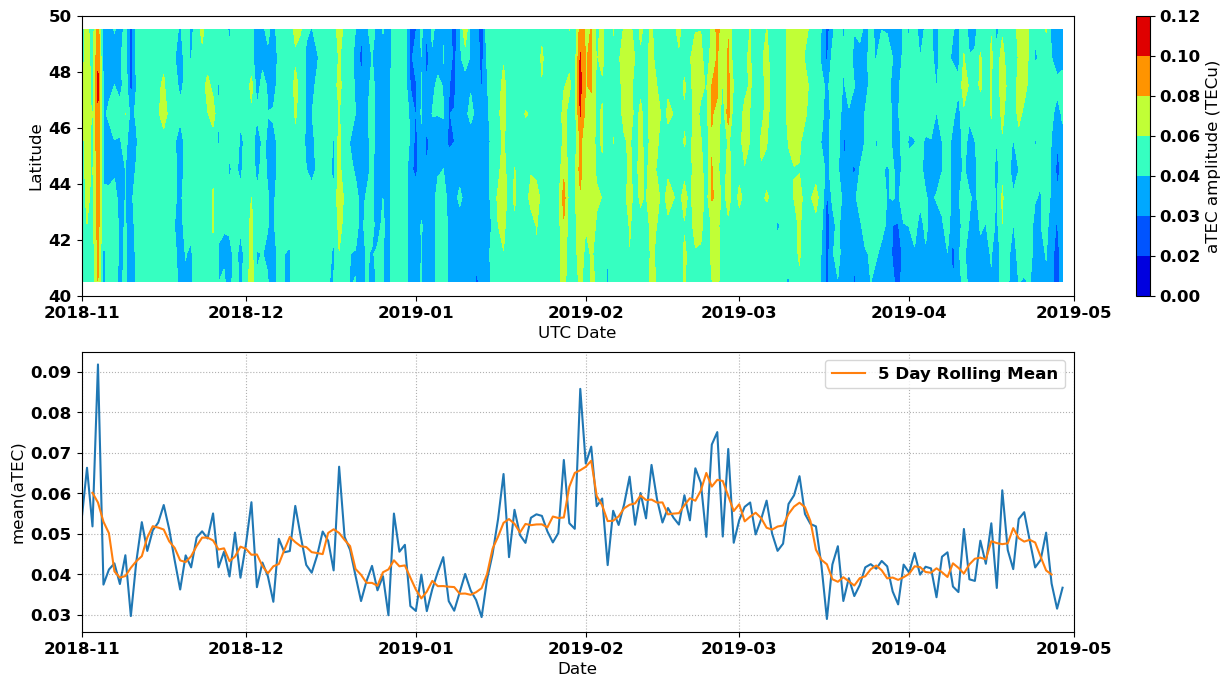

In [8]:
atec_obj   = gnss_dtec_gw.GNSS_dTEC_GW()

# lat_0 = None
# lat_1 = None

lat_0 = 40.
lat_1 = 50.

if lat_0 is not None:
    tf    = atec_obj.lats >= lat_0
    atec_obj.dtec = atec_obj.dtec[:,tf]
    atec_obj.lats = atec_obj.lats[tf]

if lat_1 is not None:
    tf    = atec_obj.lats < lat_1
    atec_obj.dtec = atec_obj.dtec[:,tf]
    atec_obj.lats = atec_obj.lats[tf]
    
atec_mean = np.nanmean(atec_obj.dtec,1)

atec_df   = pd.DataFrame({'atec_mean':atec_mean},index=atec_obj.dates[:-1])

rolling_days = 5
atec_df['atec_rolling'] = atec_df['atec_mean'].rolling(rolling_days,center=True).mean()

##### PLOTTING #####
nrows  = 2
ax_inx = 0

fig = plt.figure(figsize=(16,8))
ax_inx     += 1
ax          = fig.add_subplot(nrows,1,ax_inx)
ax_0        = ax
atec_result = atec_obj.plot_ax(ax)
ax.set_ylim(lat_0,lat_1)
ax.set_xlim(xlim_0,xlim_1)

ax_inx += 1
ax      = fig.add_subplot(nrows,1,ax_inx)
ax_1    = ax
xx      = atec_df.index
yy      = atec_df['atec_mean']
ax.plot(xx,yy)
ax.plot(xx,atec_df['atec_rolling'],label='{!s} Day Rolling Mean'.format(rolling_days))

ax.set_xlabel('Date')
ax.set_ylabel('mean(aTEC)')
ax.set_xlim(xlim_0,xlim_1)

ax.legend(loc='upper right')

adjust_axes(ax_1,ax_0)
plt.show()

# Correlation Analysis

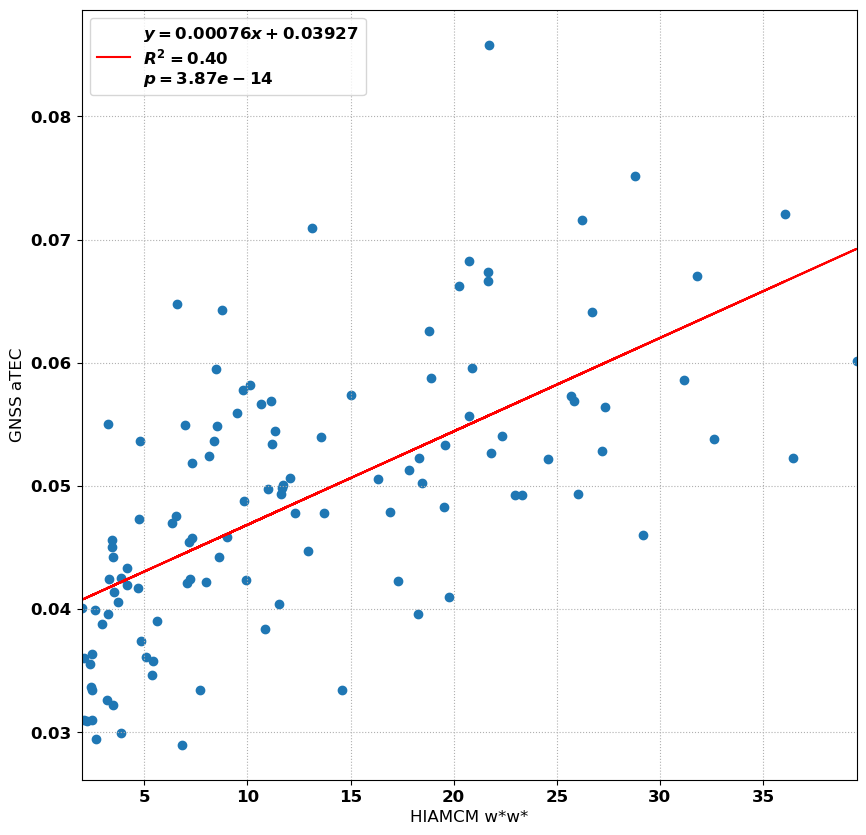

In [9]:
df = pd.concat([ww_df,atec_df],axis=1)
df = df.dropna()

xx  = df['ww_mean']
yy  = df['atec_mean']
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(xx, yy)

lbl = []
lbl.append('$y={:0.5f}x + {:0.5f}$'.format(slope,intercept))
lbl.append('$R^2 = {:.2f}$'.format(r_value**2))
lbl.append('$p = {:.3g}$'.format(p_value))

lbl = '\n'.join(lbl)

yy_line = slope*xx + intercept

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(1,1,1)

ax.scatter(xx,yy)
ax.plot(xx,yy_line,color='r',label=lbl)
ax.legend(loc='upper left')

ax.set_xlabel('HIAMCM w*w*')
ax.set_ylabel('GNSS aTEC')
plt.show()

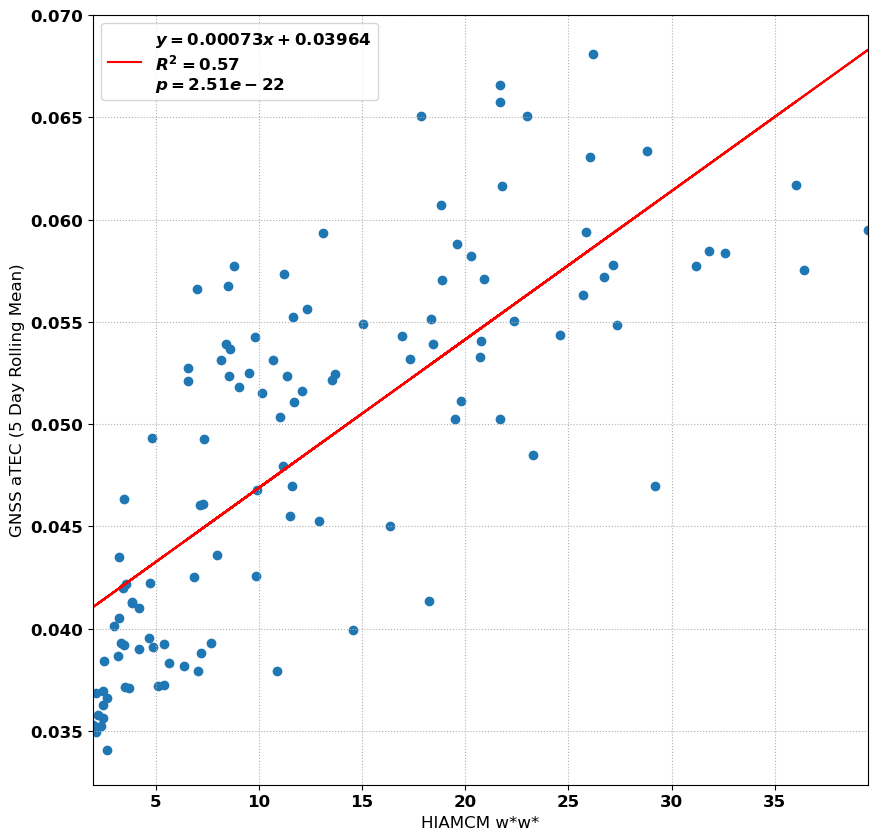

In [10]:
df = pd.concat([ww_df,atec_df],axis=1)
df = df.dropna()

xx  = df['ww_mean']
yy  = df['atec_rolling']
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(xx, yy)

lbl = []
lbl.append('$y={:0.5f}x + {:0.5f}$'.format(slope,intercept))
lbl.append('$R^2 = {:.2f}$'.format(r_value**2))
lbl.append('$p = {:.3g}$'.format(p_value))

lbl = '\n'.join(lbl)

yy_line = slope*xx + intercept

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(1,1,1)

ax.scatter(xx,yy)
ax.plot(xx,yy_line,color='r',label=lbl)
ax.legend(loc='upper left')

ax.set_xlabel('HIAMCM w*w*')
ax.set_ylabel('GNSS aTEC (5 Day Rolling Mean)')
plt.show()